In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
sys.path.append('..\model')
from BathPlateModel import BathPlateModel

model=BathPlateModel(holes=2,outerBox="sphere", boxx=0.2, div_thick=1)
DrawGeo(model.model)
mesh=model.mesh
Draw(mesh)

Bath Plate Model    holes: 2    Thickness: 0.00635
boxx=  0.2  boxy=  0.28  boxz=  0.4
div_thick=  1
name: hole1   mass: 7.619999999999999e-06   center: (0.02, 3.21245e-20, 5.42769e-20)
name: hole2   mass: 7.619999999999999e-06   center: (-0.02, 3.21245e-20, 5.42769e-20)
name: to_side   mass: 1.3335000000000002e-05   center: (9.92493e-19, 0.0178571, -1.50111e-20)
name: from_side   mass: 1.3335000000000002e-05   center: (0, -0.0178571, 4.91339e-21)
name: air   mass: 9.542999999999996e-05   center: (0, -3.46717e-19, -6.29917e-19)
name: reduced   mass: 0.033372981638291145   center: (-1.29696e-17, -1.45627e-17, 9.02153e-20)
conductive_region: to_side|from_side
Conductor boundary: conductorBND|interface|interface2
{'conductor': 32780000.0, 'to_side': 32780000.0, 'from_side': 32780000.0, 'air': 0, 'reduced': 0, 'hole1': 0, 'hole2': 0, 'default': 0}
{'conductor': 1.2566370614359173e-06, 'to_side': 1.2566370614359173e-06, 'from_side': 1.2566370614359173e-06, 'air': 1.2566370614359173e-06, 're

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

Model
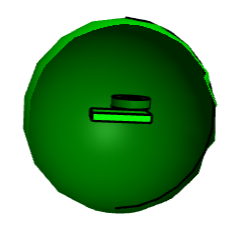
      Mesh
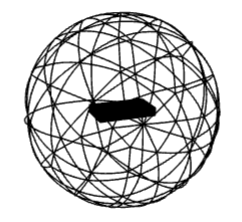

In [2]:
import math
feorder=3
Dirichlet=False
jomega=True
f=50
if jomega==True:
    s=2j*math.pi*f
else:
    s=2*math.pi*f
    
symmetric_plane=model.symmetric_plane
Mu=model.Mu
Sigma=model.Sigma
reduced_region=model.reduced_region
total_region=model.total_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary
conductive_region=model.conductive_region

coil=model.coil.field
Av=Afield(coil)
Bv=Bfield(coil)
mu=4.e-7*math.pi
Hv=Bv/mu
As=model.ReducedField(Av, (0,0,0))
Bs=model.ReducedField(Bv, (0,0,0))

if Dirichlet==True:
    fesA=HCurl(mesh, order=feorder, dirichlet=symmetric_plane+'|'+reduced_boundary, nograds=True, complex=jomega)
else:
    fesA=HCurl(mesh, order=feorder, dirichlet=symmetric_plane, nograds=True, complex=jomega) 
A, N = fesA.TnT() 
gfA= GridFunction(fesA)
normal = specialcf.normal(mesh.dim)

a= BilinearForm(fesA)
a +=1/Mu*curl(A)*curl(N)*dx
a +=s*Sigma*A*N*dx(conductive_region)
with TaskManager():
    a.Assemble()

# Calculate Dirichlet condition terms
gfA.Set(Av, BND, mesh.Boundaries(total_boundary))
f = LinearForm(fesA)
f +=1/Mu*curl(gfA)*curl(N)*dx(reduced_region)

with TaskManager():
    f.Assemble()    
#remove components of the Dirichlet boundary
fcut = np.array(f.vec.FV())[fesA.FreeDofs()]
np.array(f.vec.FV(), copy=False)[fesA.FreeDofs()] = fcut

# Add Neumann condition terms
f += Cross(N.Trace(),Hv)*normal*ds(total_boundary)
with TaskManager():
    f.Assemble()
gfA= GridFunction(fesA)   #Clear gfA
gfA=solver.iccg_solve(fesA, gfA, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, complex=jomega) 

fesAt=HCurl(mesh, order=feorder, definedon=total_region, dirichlet=symmetric_plane, nograds=True, complex=jomega)
fesAr=HCurl(mesh, order=feorder, definedon=reduced_region, dirichlet=symmetric_plane, nograds=True, complex=jomega)
At=GridFunction(fesAt)
Arr=GridFunction(fesAr)
Axr=GridFunction(fesAr)
At.Set(gfA,VOL, definedon=total_region)
Arr.Set(gfA,VOL, definedon=reduced_region)
Axr.Set(Av, BND, mesh.Boundaries(total_boundary))

Bt=curl(At)
Ar=Arr-Axr
Br=curl(Arr)-curl(Axr)

Afield=At+Ar+As
Bfield=Bt+Br+Bs
Jfield=-s*Sigma*At
   
mip = mesh(0,0,0)
print("center magnetic field = ", Bfield(mip))


enter iccg_solve
Dof= 127779    matrix size= 3016975.0
結果のノルム: 2.199750535451607e-07
power=  (0.05729792517815124-0.0016282252963504328j)
center magnetic field =  ((0.004484380279438017-0.0006774301590293946j), (4.085063169310458e-05+0.00012002858768788457j), (0.007051954095915918-0.0019389145459173748j))


In [3]:
if jomega==False:
    WJ=Integrate(Jfield*Jfield/Sigma*dx(conductive_region, mesh))
else:
    WJ=Integrate((Jfield.real*Jfield.real+Jfield.imag*Jfield.imag)/Sigma*dx(conductive_region), mesh) /2
print(" Average Joule loss= ", WJ)

 Average Joule loss=  0.25576084346818306


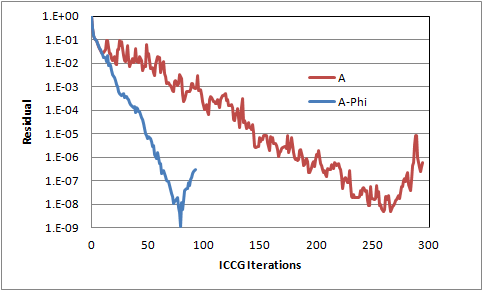

A:     Average Joule loss= 0.25576084346818306

A-Phi: Average Joule loss= 0.24944676713674657

2.5% difference

In [4]:
if jomega==True:
    print("****** Bfield.real ******")
    Draw (Bfield.real, mesh, order=3, deformation=False) 
    print("****** Bfield.imag ******")
    Draw (Bfield.imag, mesh, order=3, deformation=False) 
    print("****** Jfield.real ******")
    Draw (Jfield.real, mesh, order=3, deformation=False) 
    print("****** Jfield.imag ******")
    Draw (Jfield.imag, mesh, order=3, deformation=False) 
else:
    print("****** Bfield ******")
    Draw (Bfield, mesh, order=3, deformation=False) 
    print("****** Jfield ******")
    Draw (Jfield, mesh, order=3, deformation=False) 

****** Bfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Bfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Some diffrences are observed.

A:      J field img [0,2e6]
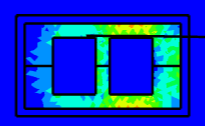

A-Phi; J field imag [0,2e6]
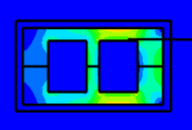